In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
educacion = gpd.read_file('educacion.geojson')
comunas_urbanas = gpd.read_file('r13.geojson')
rutasBuses = gpd.read_file('rutasBuses.geojson')

In [3]:
comuna_codes = {
    '13101': 'Santiago', '13102': 'Cerrillos', '13103': 'Cerro Navia', '13104': 'Conchali',
    '13105': 'El Bosque', '13106': 'Estacion Central', '13107': 'Huechuraba', 
    '13108': 'Independencia', '13109': 'La Cisterna', '13110': 'La Florida',
    '13111': 'La Granja', '13112': 'La Pintana', '13113': 'La Reina', 
    '13114': 'Las Condes', '13115': 'Lo Barnechea', '13116': 'Lo Espejo',
    '13117': 'Lo Prado', '13118': 'Macul', '13119': 'Maipu', '13120': 'Nunoa',
    '13121': 'Pedro Aguirre Cerda', '13122': 'Penalolen', '13123': 'Providencia',
    '13124': 'Pudahuel', '13125': 'Quilicura', '13126': 'Quinta Normal',
    '13127': 'Recoleta', '13128': 'Renca', '13129': 'San Joaquin', 
    '13130': 'San Miguel', '13131': 'San Ramon', '13132': 'Vitacura',
    '13201': 'Puente Alto'
}

In [4]:
comunas_urbanas = comunas_urbanas[comunas_urbanas['codigo_comuna'].astype(str).isin(comuna_codes.keys())]

comunas_urbanas['nombre_comuna'] = comunas_urbanas['codigo_comuna'].map(comuna_codes)

In [5]:
comunas_urbanas = comunas_urbanas.dissolve(by='codigo_comuna', as_index=False)

In [6]:
comunas_urbanas = comunas_urbanas.to_crs(educacion.crs)
rutasBuses = rutasBuses.to_crs(educacion.crs)

In [7]:
comunas_urbanas = comunas_urbanas.to_crs(educacion.crs)
rutasBuses = rutasBuses.to_crs(educacion.crs)

educacion_en_comuna = gpd.sjoin(educacion, comunas_urbanas, how='inner', predicate='within')

edu_counts = educacion_en_comuna.groupby('codigo_comuna').size().reset_index(name='num_zonas_educativas')


In [8]:
rutasBuses = rutasBuses[rutasBuses.geometry.type.isin(['LineString', 'MultiLineString'])]

if comunas_urbanas.crs.is_geographic:
    rutasBuses = rutasBuses.to_crs(epsg=3857)  
    comunas_urbanas_proj = comunas_urbanas.to_crs(epsg=3857)
else:
    comunas_urbanas_proj = comunas_urbanas

rutas_en_comuna = gpd.overlay(rutasBuses, comunas_urbanas_proj, how='intersection')

rutas_en_comuna['length'] = rutas_en_comuna.geometry.length

rutas_length = rutas_en_comuna.groupby('codigo_comuna')['length'].sum().reset_index(name='longitud_rutas_m')

In [9]:
comunas_urbanas = comunas_urbanas.merge(edu_counts, on='codigo_comuna', how='left')

comunas_urbanas = comunas_urbanas.merge(rutas_length, on='codigo_comuna', how='left')

comunas_urbanas['num_zonas_educativas'] = comunas_urbanas['num_zonas_educativas'].fillna(0)
comunas_urbanas['longitud_rutas_m'] = comunas_urbanas['longitud_rutas_m'].fillna(0)

comunas_urbanas['area_m2'] = comunas_urbanas.geometry.area
comunas_urbanas['densidad_zonas_educativas'] = comunas_urbanas['num_zonas_educativas'] / comunas_urbanas['area_m2'] * 1e6  # por km²
comunas_urbanas['densidad_rutas_m_km2'] = comunas_urbanas['longitud_rutas_m'] / comunas_urbanas['area_m2'] * 1e6  # metros por km²


/var/folders/cw/q3kmrhcj05j6p8f0f9dpby7r0000gn/T/ipykernel_63419/184432510.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  comunas_urbanas['area_m2'] = comunas_urbanas.geometry.area


In [10]:
datos_corr = comunas_urbanas[['num_zonas_educativas', 'longitud_rutas_m']].copy()

correlacion = datos_corr.corr()

print("Matriz de Correlación:")
print(correlacion)

coeficiente = correlacion.loc['num_zonas_educativas', 'longitud_rutas_m']
print(f"\nCoeficiente de correlación entre zonas educativas y longitud de rutas de buses: {coeficiente:.2f}")


Matriz de Correlación:
                      num_zonas_educativas  longitud_rutas_m
num_zonas_educativas              1.000000          0.551953
longitud_rutas_m                  0.551953          1.000000

Coeficiente de correlación entre zonas educativas y longitud de rutas de buses: 0.55


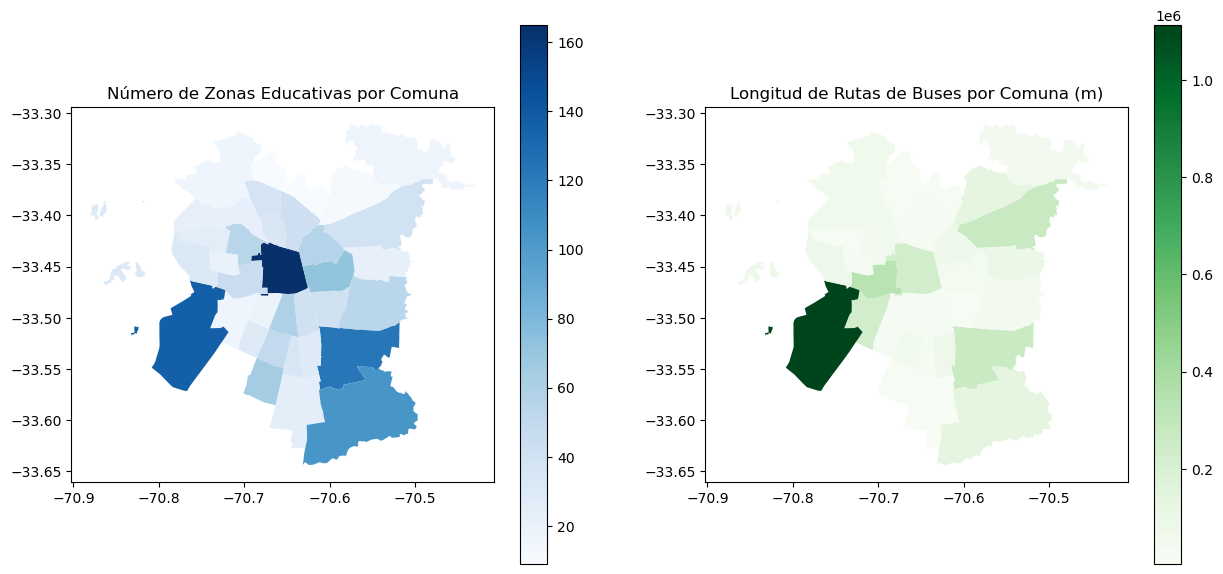

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7))

comunas_urbanas.plot(column='num_zonas_educativas', cmap='Blues', legend=True, ax=ax[0])
ax[0].set_title('Número de Zonas Educativas por Comuna')

comunas_urbanas.plot(column='longitud_rutas_m', cmap='Greens', legend=True, ax=ax[1])
ax[1].set_title('Longitud de Rutas de Buses por Comuna (m)')

fig.savefig('educacion_rutas.png')
plt.show()


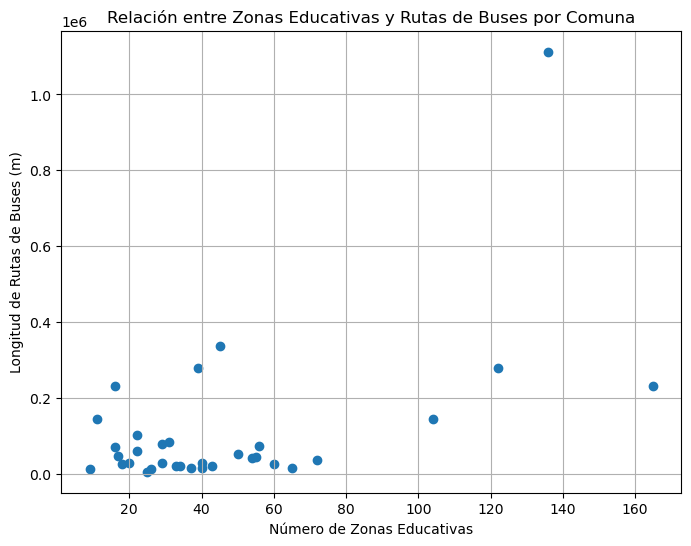

In [12]:
plt.figure(figsize=(8,6))
plt.scatter(comunas_urbanas['num_zonas_educativas'], comunas_urbanas['longitud_rutas_m'])
plt.xlabel('Número de Zonas Educativas')
plt.ylabel('Longitud de Rutas de Buses (m)')
plt.title('Relación entre Zonas Educativas y Rutas de Buses por Comuna')
plt.grid(True)
plt.show()